## Calculate temperature profiles under different modelling assumptions

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../../"))
if !haskey(ENV, "RAD_DIR")
    ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")
end

In [2]:
# Import system packages
using Pkg
using Revise

using Printf
using DelimitedFiles
using Plots
default(label=nothing, grid=true)

In [23]:
using LaTeXStrings

In [3]:
# Import AGNI
Pkg.activate(ROOT_DIR)
using AGNI

# Normal logging from AGNI module
AGNI.setup_logging("",2)

  Activating project at `~/AGNI`


In [4]:
R_earth = 6.371e6 # m
S_earth = 1361.0 # W/m^2

1361.0

### Define atmosphere parameters

In [5]:
# Configuration options
instellation    = 2 * S_earth  # Solar flux [W m-2]
gravity         = 9.81
radius          = 1 * R_earth
zenith          = 54.74
albedo          = 0.0
s0_fact         = 0.25
nlev_centre     = 50
p_surf          = 300.0     # bar
t_surf          = 2000.0
p_top           = 1e-5      # bar
mole_fractions  = Dict([ ("H2O", 0.4), ("H2", 0.6)])

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/256/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt");


In [6]:
# Create output directory
output_dir = joinpath(ROOT_DIR,"out")
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [7]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo, zenith,
                        t_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=true
                        )
atmosphere.allocate!(atmos, star_file)
setpt.isothermal!(atmos, t_surf)

[ INFO  ] Setting-up a new atmosphere struct 
[ DEBUG ] AGNI VERSION = 1.7.9 
[ DEBUG ] Using SOCRATES at /home/n/nichollsh/AGNI/socrates 
[ DEBUG ] SOCRATES VERSION = 2407.2 
[ DEBUG ] Composition set by dict 
[ INFO  ] Loading thermodynamic data 
[ DEBUG ] Loading data for gas H2O 
[ DEBUG ]     ncdf 
[ DEBUG ]     using 'AQUA' equation of state 
[ DEBUG ]     done 
[ DEBUG ] Loading data for gas H2 
[ DEBUG ]     ncdf 
[ DEBUG ]     using 'CMS19' equation of state 
[ DEBUG ]     done 
[ DEBUG ] FastChem env has been set 
[ DEBUG ] Found FastChem executable 
[ DEBUG ] Fastchem working dir defaulting to /home/n/nichollsh/AGNI/out/fastchem/ 
[ DEBUG ] Setup complete 
[ DEBUG ] Allocate atmosphere 
[ DEBUG ] Inserting stellar spectrum into spectral file 
[ DEBUG ] Inserting stellar spectrum from file /home/n/nichollsh/AGNI/res/stellar_spectra/sun.txt 
[ DEBUG ] Read stellar spectrum from file 
[ DEBUG ] Writing stellar spectrum to SOCRATES format 
[ DEBUG ] Using prep_spec at: /home/n/n

In [8]:
atmos_results::Dict{String, atmosphere.Atmos_t} = Dict{String, atmosphere.Atmos_t}()

Dict{String, AGNI.atmosphere.Atmos_t}()

## Run the model under various scenarios

### Fixed surface temperature

In [9]:
atmos.tmp_surf = deepcopy(t_surf)
println(atmos.tmp_surf)

2000.0


In [10]:
# Isothermal
setpt.isothermal!(atmos, atmos.tmp_surf)
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos, true, false, true, false, false)
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_iso"] = deepcopy(atmos)
;

In [11]:
# Adiabatic
setpt.dry_adiabat!(atmos)
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos, true, false, true, false, false)
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_ad"] = deepcopy(atmos)
;

In [12]:
# Adiabatic + stratosphere
setpt.dry_adiabat!(atmos)
setpt.stratosphere!(atmos, phys.calc_Tskin(atmos.instellation, atmos.albedo_b))
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos, true, false, true, false, false)
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_ad+strat"] = deepcopy(atmos)
;

In [13]:
# Radiative-convective
setpt.isothermal!(atmos, t_surf) # initial guess
succ = solver.solve_energy!(atmos,
                                    sol_type=1,
                                    method=1,
                                    dx_max=200.0,
                                    ls_method=2,
                                    modplot=0,
                                    save_frames=false,
                                    detect_plateau=false
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_radconv"] = deepcopy(atmos)
;

[ INFO  ]     chem_type = 0 
[ INFO  ]     sol_type  = 1 
[ INFO  ]     tmp_surf  = 2000.00 K 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        1  -5.62e+02  2.233e+05  7.260e+05  2.000e+03  1.400e+02  C2-Nr-Ls 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        2  -3.42e+02  1.445e+05  4.888e+05  2.000e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        3  -2.86e+02  1.064e+05  3.505e+05  2.000e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        4  -2.18e+02  7.725e+04  2.490e+05  2.000e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ D

### Solving for energy balance

In [14]:
# Isothermal
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=1, tmp_upper=1000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_iso"] = deepcopy(atmos)
;

[ DEBUG ]     try tmp_surf = 383.2020792276049 K 
[ DEBUG ]     flux_tot = 892.6060138827356 
[ DEBUG ]     try tmp_surf = 618.7979207723951 K 
[ DEBUG ]     flux_tot = 7977.8540249594025 
[ DEBUG ]     try tmp_surf = 237.5958415447901 K 
[ DEBUG ]     flux_tot = -150.47589186411318 
[ DEBUG ]     try tmp_surf = 147.6062376828148 K 
[ DEBUG ]     flux_tot = -303.50999906796244 
[ DEBUG ]     try tmp_surf = 293.21247536562964 K 
[ DEBUG ]     flux_tot = 90.1129047859103 
[ DEBUG ]     try tmp_surf = 327.58544540676536 K 
[ DEBUG ]     flux_tot = 323.49592358005594 
[ DEBUG ]     try tmp_surf = 271.96881158592583 K 
[ DEBUG ]     flux_tot = -18.80971422028705 
[ DEBUG ]     try tmp_surf = 258.83950532449387 K 
[ DEBUG ]     flux_tot = -75.99994624696785 
[ DEBUG ]     try tmp_surf = 280.0831691041977 K 
[ DEBUG ]     flux_tot = 20.119762200948912 
[ DEBUG ]     try tmp_surf = 266.95386284276566 K 
[ DEBUG ]     flux_tot = -41.91800626079288 
[ DEBUG ]     try tmp_surf = 275.0682203610374

In [15]:
# Adiabatic
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=2)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_ad"] = deepcopy(atmos)
;

[ DEBUG ]     try tmp_surf = 1911.0661242280253 K 
[ DEBUG ]     flux_tot = -325.02860016439166 
[ DEBUG ]     try tmp_surf = 3090.9338757719747 K 
[ DEBUG ]     flux_tot = -270.84144414885395 
[ DEBUG ]     try tmp_surf = 3820.132248456051 K 
[ DEBUG ]     flux_tot = 135.00336590134935 
[ DEBUG ]     try tmp_surf = 4270.801627315924 K 
[ DEBUG ]     flux_tot = 739.3951357905573 
[ DEBUG ]     try tmp_surf = 3541.603254631847 K 
[ DEBUG ]     flux_tot = -52.62596964900888 
[ DEBUG ]     try tmp_surf = 3369.462869596179 K 
[ DEBUG ]     flux_tot = -180.53595708745132 
[ DEBUG ]     try tmp_surf = 3647.991863420383 K 
[ DEBUG ]     flux_tot = -3.1668989404071795 
[ DEBUG ]     try tmp_surf = 3713.743639667515 K 
[ DEBUG ]     flux_tot = 55.32249580883649 
[ DEBUG ]     try tmp_surf = 3607.355030878978 K 
[ DEBUG ]     flux_tot = -34.08473787015021 
[ DEBUG ]     try tmp_surf = 3673.1068071261097 K 
[ DEBUG ]     flux_tot = 17.84391187670019 
[ DEBUG ]     try tmp_surf = 3632.469974584704

In [16]:
# Adiabatic + stratosphere
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=3)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_ad+strat"] = deepcopy(atmos)
;

[ DEBUG ]     try tmp_surf = 1911.0661242280253 K 
[ DEBUG ]     flux_tot = 9.113178252470163 
[ DEBUG ]     try tmp_surf = 3090.9338757719747 K 
[ DEBUG ]     flux_tot = 110.86066233619141 
[ DEBUG ]     try tmp_surf = 1181.8677515439488 K 
[ DEBUG ]     flux_tot = 11.416238672842212 
[ DEBUG ]     try tmp_surf = 2361.735503087898 K 
[ DEBUG ]     flux_tot = 7.198311905461026 
[ DEBUG ]     try tmp_surf = 2640.2644969121025 K 
[ DEBUG ]     flux_tot = 12.507723609604682 
[ DEBUG ]     try tmp_surf = 2189.5951180522297 K 
[ DEBUG ]     flux_tot = 7.823507742515858 
[ DEBUG ]     try tmp_surf = 2468.1241118764347 K 
[ DEBUG ]     flux_tot = 7.433328396863146 
[ DEBUG ]     try tmp_surf = 2295.9837268407664 K 
[ DEBUG ]     flux_tot = 7.403599922477099 
[ DEBUG ]     try tmp_surf = 2402.372335629303 K 
[ DEBUG ]     flux_tot = 7.2316808300285516 
[ DEBUG ]     try tmp_surf = 2336.6205593821715 K 
[ DEBUG ]     flux_tot = 7.289294383485185 
[ DEBUG ]     try tmp_surf = 2377.257391923577 K

In [17]:
# Radiative-convective
setpt.isothermal!(atmos, t_surf) # initial guess
succ = solver.solve_energy!(atmos,
                                    sol_type=3,
                                    method=1,
                                    dx_max=200.0,
                                    ls_method=2,
                                    modplot=0,
                                    save_frames=false,
                                    detect_plateau=false
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_radconv"] = deepcopy(atmos)
;

[ INFO  ]     chem_type = 0 
[ INFO  ]     sol_type  = 3 
[ INFO  ]     flux_int  = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        1  -5.01e+02  7.335e+05  7.268e+05  1.931e+03  1.400e+02  C2-Nr-Ls 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        2  -3.46e+02  4.939e+05  4.900e+05  1.834e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        3  -2.24e+02  3.550e+05  3.521e+05  1.727e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        4  -1.73e+02  2.529e+05  2.508e+05  1.631e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ 

In [18]:
# save to netcdf
for (k,atm) in atmos_results
    save.write_ncdf(atm, joinpath(output_dir,k*".nc"))
end


[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_radconv.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_ad+strat.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_ad+strat.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_radconv.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_iso.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_iso.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_ad.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_ad.nc 


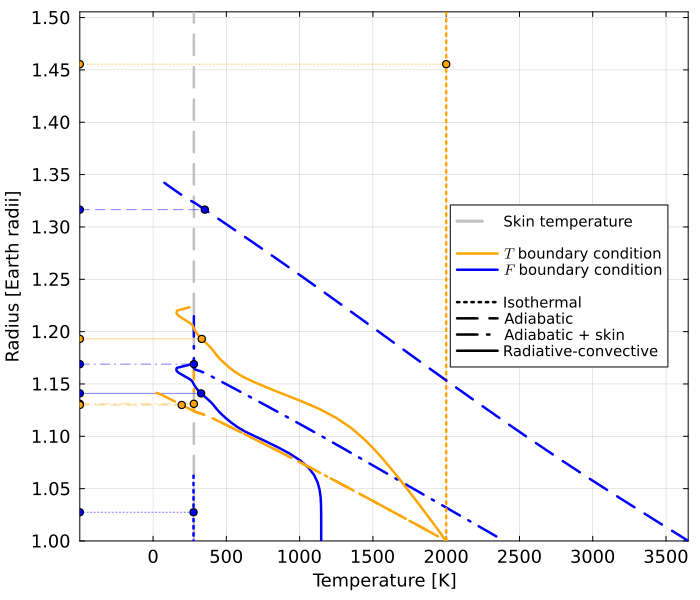

"/home/n/nichollsh/AGNI/out/plot_height.pdf"

In [62]:
fig = plot(legend=:right, size=(700,600),
            ylabel="Radius [Earth radii]",
            xlabel="Temperature [K]", legendfontsize=10, labelfontsize=12, tickfontsize=12, frame=:box)

lw = 2.5

Teqm = phys.calc_Tskin(atmos.instellation, atmos.albedo_b)
vline!(fig, [Teqm], ls=:dash, color=:silver, lw=lw, label=@sprintf("Skin temperature"))

# default axis limits
y_min = 10.0
y_max = 0.5
x_min = -500
x_max = 10.0


lstyles = Dict([("iso",:dot), ("ad",:dash), ("ad+strat",:dashdot), ("radconv",:solid)])

# plot
for (k,atm) in atmos_results

    spl = split(k,"_")

    # line label and color
    if spl[1] == "1"
        col = "orange"
    else
        col = "blue"
    end
    ls = lstyles[spl[2]]

    # plot profile
    plot!(fig, atm.tmp, atm.r / R_earth, lw=lw, linestyle=ls, color=col)

    # plot photosphere point
    atmosphere.calc_observed_rho!(atm)
    rtrans = atm.transspec_r/R_earth
    plot!(fig, [x_min, atm.transspec_tmp], [rtrans,rtrans], color=col, linealpha=0.5, linestyle=ls)
    scatter!(fig, [atm.transspec_tmp], [rtrans], color=col)
    scatter!(fig, [x_min], [rtrans], color=col)

    # axis limits
    y_min = min( minimum(atm.r) / R_earth, y_min)
    y_max = max( rtrans, y_max)
    x_max = max( maximum(atm.tmp), x_max)
end

# legend entries
llw = 2
plot!(fig, [], [], label=" ", linealpha=0) # spacer
plot!(fig, [], [], lw=llw, label=L"$T$ boundary condition", lc="orange", ls=:solid,  )
plot!(fig, [], [], lw=llw, label=L"$F$ boundary condition", lc="blue",   ls=:solid,  )
plot!(fig, [], [], label=" ", linealpha=0) # spacer
plot!(fig, [], [], lw=llw, label="Isothermal",           lc="black",  ls=:dot,    )
plot!(fig, [], [], lw=llw, label="Adiabatic",            lc="black",  ls=:dash,   )
plot!(fig, [], [], lw=llw, label="Adiabatic + skin",     lc="black",  ls=:dashdot,)
plot!(fig, [], [], lw=llw, label="Radiative-convective", lc="black",  ls=:solid,)

y_max += 0.05
yaxis!(ylim=(1.0, y_max), yticks=range(1.0, y_max, step=0.05))
xaxis!(xlim=(x_min, x_max), xticks=range(0.0, x_max, step=500))

display(fig)
savefig(fig, joinpath(output_dir,"plot_height.pdf"))